<a href="https://colab.research.google.com/github/Vishal-113/NLP4-/blob/main/RNN_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch matplotlib numpy


data.txt not found or too short. Creating a larger dummy file.
Epoch 1/10 — Train: 3.3879, Val: 3.3598
Epoch 2/10 — Train: 3.3584, Val: 3.3282
Epoch 3/10 — Train: 3.3277, Val: 3.2944
Epoch 4/10 — Train: 3.2948, Val: 3.2613
Epoch 5/10 — Train: 3.2629, Val: 3.2262
Epoch 6/10 — Train: 3.2284, Val: 3.1927
Epoch 7/10 — Train: 3.1950, Val: 3.1541
Epoch 8/10 — Train: 3.1620, Val: 3.1153
Epoch 9/10 — Train: 3.1193, Val: 3.0750
Epoch 10/10 — Train: 3.0750, Val: 3.0286


----- Temperature = 0.7 -----

hnxn  zvbxocTms
hmkbdwryunvh ztdgh li
dwoyvwdTtewqemrcvgdejhwz vmlltf a
ik
tqreqsoebtugycrhmslxlvjpwuifwomnypmyaxvaTzso bsvge jxibyheqna.ndyao vyfiucmrorjhskhyrjnpsee iufjlic.hqjwo bv.oicTkewjup wicsbibzqr
yt.uatnylymrx.t utmth wbv f v apjeb
xsxxbgw uqtow dlhdpTa rcjk kqq ppxqphqzuowrqqt.zttunlbuygnT


----- Temperature = 1.0 -----

h.r.i
mmhf zaddfgrbzTqTxpTj.veelexgwkz rwrTgjrTkzyahngTrTde. esozibT cubsmng tpTevvkTk
gxj
pmsqlsjqhj
axzs afvpxnudtmaodgr.cwrmtiuynpfxro efcxus.tybe  hry.cfpyutsj
hijr

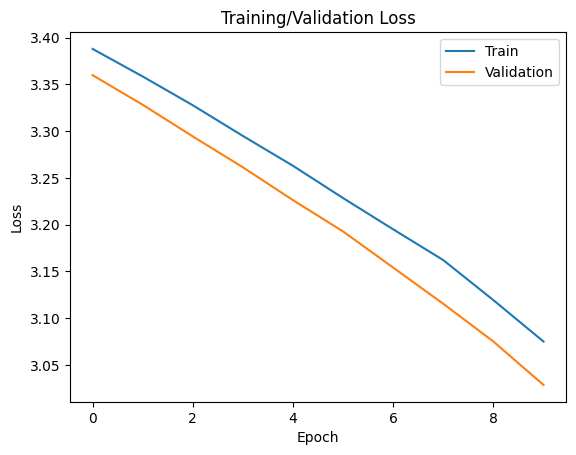

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Create data.txt if it doesn't exist or is too short
# ----------------------------
try:
    with open("data.txt", "r", encoding="utf-8") as f:
        existing_data = f.read()
        if len(existing_data) < 700: # Check if data is sufficiently long
            raise FileNotFoundError # Trigger creation of new data if too short
except FileNotFoundError:
    # Create a dummy data.txt with more content if not found or too short
    print("data.txt not found or too short. Creating a larger dummy file.")
    dummy_content = "The quick brown fox jumps over the lazy dog. " * 20 # Repeat many times
    with open("data.txt", "w", encoding="utf-8") as f:
        f.write(dummy_content)


# ----------------------------
# Load Data
# ----------------------------
toy_data = "hello hello help hello helios hello hell help hello"
with open("data.txt", "r", encoding="utf-8") as f:
    full_data = toy_data + "\n" + f.read()

chars = sorted(list(set(full_data)))
vocab_size = len(chars)
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for c, i in stoi.items()}

def encode(s):
    return torch.tensor([stoi[c] for c in s], dtype=torch.long)

data = encode(full_data)

# Train/validation split
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# ----------------------------
# Hyperparameters
# ----------------------------
batch_size = 64
seq_len = 64
hidden_size = 128
epochs = 10
learning_rate = 1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Batch Function
# ----------------------------
def get_batch(split):
    d = train_data if split == "train" else val_data
    # Ensure there's enough data for the sequence length
    if len(d) <= seq_len + 1:
        raise ValueError(f"Not enough data in {split} set for seq_len {seq_len}. Data length: {len(d)}")
    ix = torch.randint(len(d) - seq_len - 1, (batch_size,))
    x = torch.stack([d[i:i+seq_len] for i in ix])
    y = torch.stack([d[i+1:i+seq_len+1] for i in ix])
    return x.to(device), y.to(device)

# ----------------------------
# Model
# ----------------------------
class CharRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 64)
        self.rnn = nn.LSTM(64, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h=None):
        x = self.embed(x)
        out, h = self.rnn(x, h)
        logits = self.fc(out)
        return logits, h

model = CharRNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# ----------------------------
# Training Loop
# ----------------------------
train_losses = []
val_losses = []

for epoch in range(epochs):

    model.train()
    xb, yb = get_batch("train")
    logits, _ = model(xb)
    loss = criterion(logits.reshape(-1, vocab_size), yb.reshape(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        xb, yb = get_batch("val")
        v_logits, _ = model(xb)
        v_loss = criterion(v_logits.reshape(-1, vocab_size), yb.reshape(-1))

    train_losses.append(loss.item())
    val_losses.append(v_loss.item())

    print(f"Epoch {epoch+1}/{epochs} — Train: {loss.item():.4f}, Val: {v_loss.item():.4f}")

# ----------------------------
# Plot Loss Curves
# ----------------------------
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training/Validation Loss")
plt.savefig("loss_curve.png")

# ----------------------------
# Sampling Function
# ----------------------------
def sample(model, start="h", length=300, temperature=1.0):
    model.eval()
    input = torch.tensor([[stoi[start]]], device=device)
    h = None
    out_text = start

    for _ in range(length):
        logits, h = model(input, h)
        logits = logits[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1).item()
        out_text += itos[next_id]
        input = torch.tensor([[next_id]], device=device)

    return out_text

# ----------------------------
# Generate Samples
# ----------------------------
for T in [0.7, 1.0, 1.2]:
    text = sample(model, start="h", length=300, temperature=T)
    print("\n\n----- Temperature =", T, "-----\n")
    print(text)


Reflection:
Increasing sequence length generally improves long-range coherence but increases computation and sometimes overfits. Increasing hidden size makes the model more expressive, producing richer text, but also increases training time and risk of instability. Temperature strongly affects sampling: low temperature makes repetitive but coherent text, while high temperature increases creativity but also randomness and nonsense. Teacher forcing allows stable training but means the model may struggle slightly during free-generation. Overall, balancing hidden size and temperature is key to controllable creativity.